Purpose of this script: quickly check that changing the functional form of the background fit doesn't change N_sig, N_bkg a lot

In [1]:

import numpy as np
import matplotlib.pyplot as plt
plt.style.use("../science.mplstyle")

from sklearn.utils import shuffle


import argparse
import os

from matplotlib.backends.backend_pdf import PdfPages
import pickle

from helpers.data_transforms import inverse_transform, clean_data
from helpers.BDT import *
from helpers.physics_functions import *
from helpers.evaluation import assemble_banded_datasets

In [2]:
import yaml
with open("workflow.yaml", "r") as file:
    workflow = yaml.safe_load(file)
    
config_id = "CATHODE_8"
project_id = "lowmass"

configs_path = f"configs/{config_id}.yml"
with open(configs_path, "r") as file:
    flow_configs = yaml.safe_load(file)

In [3]:
flow_id = "mix_2"
particle_type = "upsilon_iso"
num_to_ensemble = 5
num_bootstraps = 1
dir_id = "logit_08_22"
jet_id = "nojet"
seeds = "1,2,3,4,5"
train_samesign = False

In [4]:
if "upsilon" in particle_type:
    particle_id = "upsilon"
elif "psi_prime" in particle_type:
    particle_id = "psi_prime"
elif "eta" in particle_type:
    particle_id = "eta"
elif "rho" in particle_type:
    particle_id = "rho"
elif "psi" in particle_type:
    particle_id = "psi"

project_id = "lowmass"

if train_samesign:
    train_data_id = "_samesign"
else:
    train_data_id = ""

# train on opp sign means alt test set is samesign
if train_data_id == "": 
    alt_test_data_id = "_samesign"
    train_data_id_title = "_oppsign"
elif train_data_id == "_samesign": 
    alt_test_data_id = ""
    train_data_id_title = "_samesign"

    

bands = ["SBL", "SR", "SBH"]
data_dict = {}

working_dir = f"/global/cfs/cdirs/m3246/rmastand/dimuonAD/projects/{dir_id}/"
flow_training_dir = f"{working_dir}/models/{project_id}_{particle_type}{train_data_id}_{jet_id}/{flow_id}/{config_id}"


In [5]:
# load in the flow samples corresponding to the train id
seeds_list = [int(x) for x in seeds.split(",")]
train_samples_dict = {'SR_samples_ROC':[], 'SBL_samples_ROC':[], 'SBH_samples_ROC':[], 'SR_samples_validation':[], 'SR_samples':[]}
for seed in seeds_list:
    path_to_samples = f"{flow_training_dir}/seed{seed}/flow_samples"
    with open(path_to_samples, "rb") as infile: 
        loc_train_samples_dict = pickle.load(infile)
        for key in train_samples_dict.keys():
            train_samples_dict[key].append(loc_train_samples_dict[key])
for key in train_samples_dict.keys():
    train_samples_dict[key] = np.vstack(train_samples_dict[key])
    print(key, train_samples_dict[key].shape)
           


# load in the data corresponding to the train id
# we actually want the "test band" here -- train is just for flow
with open(f"{working_dir}/processed_data/{project_id}_{particle_type}{train_data_id}_{jet_id}_test_band_data", "rb") as infile: 
    test_data_dict = pickle.load(infile)

# load in the alternative data
with open(f"{working_dir}/processed_data/{project_id}_{particle_type}{alt_test_data_id}_{jet_id}_test_band_data", "rb") as infile: 
    alt_test_data_dict = pickle.load(infile)


with open(f"{working_dir}/processed_data/{project_id}_{particle_type}_{jet_id}_train_band_data", "rb") as infile: 
    ROC_test_data_1_dict = pickle.load(infile)
    
# ROC set 2 is evaluated on a higher stats version of the flow samples (so may be same or opp sign)

print(f"Loading classifier train samples from {project_id}_{particle_type}{train_data_id}")
print(f"Loading classifier train data from {project_id}_{particle_type}{train_data_id}")
print(f"Loading alternative test data from {project_id}_{particle_type}{alt_test_data_id}")
print(f"Loading ROC test data from {project_id}_{particle_type}_{jet_id}")
print()

with open(f"{working_dir}/models/{project_id}_{particle_type}{train_data_id}_{jet_id}/{flow_id}/{config_id}/seed1/configs.txt", "rb") as infile: 
    configs = infile.readlines()[0].decode("utf-8")
    
    feature_set = [x.strip() for x in configs.split("'")][1::2]

print(feature_set)

n_features = len(feature_set) - 1


SR_samples_ROC (548300, 4)
SBL_samples_ROC (390240, 4)
SBH_samples_ROC (1533385, 4)
SR_samples_validation (548300, 4)
SR_samples (548300, 4)
Loading classifier train samples from lowmass_upsilon_iso
Loading classifier train data from lowmass_upsilon_iso
Loading alternative test data from lowmass_upsilon_iso_samesign
Loading ROC test data from lowmass_upsilon_iso_nojet

['dimu_pt', 'mu0_ip3d', 'mu1_ip3d', 'dimu_mass']


In [6]:
# Assemble the test sets -- consists of both SB and SR
        
# test set events: not used during flow training
banded_test_data = assemble_banded_datasets(test_data_dict, feature_set, bands)

# alt test set events
banded_alt_test_data = assemble_banded_datasets(alt_test_data_dict, feature_set, bands)

# ROC test set events
banded_ROC_test_data = assemble_banded_datasets(ROC_test_data_1_dict, feature_set, bands)

num_test_events = banded_test_data["SR"].shape[0]+banded_test_data["SBL"].shape[0]+banded_test_data["SBH"].shape[0]
print(f"Total number of default test events: {num_test_events}.")
num_test_events = banded_alt_test_data["SR"].shape[0]+banded_alt_test_data["SBL"].shape[0]+banded_alt_test_data["SBH"].shape[0]
print(f"Total number of alt test events: {num_test_events}.")
num_test_events = banded_ROC_test_data["SR"].shape[0]+banded_ROC_test_data["SBL"].shape[0]+banded_ROC_test_data["SBH"].shape[0]
print(f"Total number of ROC test events: {num_test_events}.")
num_test_events = banded_ROC_test_data["SR"].shape[0]+banded_ROC_test_data["SBL"].shape[0]+banded_ROC_test_data["SBH"].shape[0]
print(f"Total number of ROC test samples: {num_test_events}.")


SR_min_rescaled = np.min(banded_test_data["SR"][:,-1])
SR_max_rescaled = np.max(banded_test_data["SR"][:,-1])



Total number of default test events: 24998.
Total number of alt test events: 24998.
Total number of ROC test events: 476346.
Total number of ROC test samples: 476346.


In [7]:



# BDT HYPERPARAMETERS 



bdt_hyperparams_dict = {
    "n_estimators": 300, # number of boosting stages
    "max_depth":3, # max depth of individual regression estimators; related to complexity
    "learning_rate":0.1,  # stop training BDT is validation loss doesn't improve after this many rounds
    "subsample":0.7,   # fraction of samples to be used for fitting the individual base learners
    "early_stopping_rounds":10,
    "n_ensemble": num_to_ensemble
    
}

n_folds = 5

all_test_data_splits = {pseudo_e:{} for pseudo_e in range(num_bootstraps)}
all_scores_splits = {pseudo_e:{} for pseudo_e in range(num_bootstraps)}
all_alt_data_splits = {pseudo_e:{} for pseudo_e in range(num_bootstraps)}
all_alt_scores_splits = {pseudo_e:{} for pseudo_e in range(num_bootstraps)}

def bootstrap_array(data_array):
    indices_to_take = np.random.choice(range(data_array.shape[0]), size = data_array.shape[0], replace = True) 
    #return data_array[indices_to_take]
    return data_array

for pseudo_e in range(num_bootstraps):
    
    print(f"On pseudoexperiment {pseudo_e+1} of {num_bootstraps}...")
    
    # assemble the bootstrapped datasets
    # I think the validation set and the flow samples should NOT be bootstrapped
    
    # boostrapped alt set:
    loc_alt_test_set = np.vstack([bootstrap_array(banded_alt_test_data["SR"]),bootstrap_array(banded_alt_test_data["SBL"]),bootstrap_array(banded_alt_test_data["SBH"])])
    loc_ROC_test_events_1 = np.vstack([bootstrap_array(banded_ROC_test_data["SR"]),bootstrap_array(banded_ROC_test_data["SBL"]),bootstrap_array(banded_ROC_test_data["SBH"])])
    loc_ROC_test_samples_2 = np.vstack([bootstrap_array(train_samples_dict["SR_samples_ROC"]),bootstrap_array(train_samples_dict["SBL_samples_ROC"]),bootstrap_array(train_samples_dict["SBH_samples_ROC"])])
    loc_SB_test_set = np.vstack([bootstrap_array(clean_data(banded_test_data["SBL"])),bootstrap_array(clean_data(banded_test_data["SBH"]))])
    loc_FPR_val_set = train_samples_dict["SR_samples_validation"]
    loc_SR_data = clean_data(banded_test_data["SR"])
    loc_SR_samples = clean_data(train_samples_dict["SR_samples"])
    

    loc_alt_test_sets_data = {"FPR_validation":loc_FPR_val_set,
                      "alt":loc_alt_test_set,
                      "ROC_data":loc_ROC_test_events_1,
                     "ROC_samples":loc_ROC_test_samples_2}
    
    # make sure the input data is also bootstrapped
    loc_test_data_splits, loc_scores_splits, loc_alt_data_splits, loc_alt_scores_splits = run_BDT_bump_hunt(loc_SR_samples, bootstrap_array(loc_SR_data), loc_SB_test_set, n_folds, bdt_hyperparams_dict, alt_test_sets_data=loc_alt_test_sets_data, visualize=False, pdf=None, take_ensemble_avg=True)

    all_test_data_splits[pseudo_e] = loc_test_data_splits
    all_scores_splits[pseudo_e] = loc_scores_splits
    all_alt_data_splits[pseudo_e] = loc_alt_data_splits
    all_alt_scores_splits[pseudo_e] = loc_alt_scores_splits
    
    
    print(10*"*"+"\n")

print("Done training BDTs!")


On pseudoexperiment 1 of 1...
Fold 0:
X train shape: (332469, 3), Y train shape: (332469, 1), w train shape: (332469, 1).
X val shape: (110823, 3), Y val shape: (110823, 1), w val shape: (110823, 1).
X test shape: (5000, 3).
   Network number: 0
Fold 1:
X train shape: (332469, 3), Y train shape: (332469, 1), w train shape: (332469, 1).
X val shape: (110823, 3), Y val shape: (110823, 1), w val shape: (110823, 1).
X test shape: (5000, 3).
   Network number: 0
Fold 2:
X train shape: (332469, 3), Y train shape: (332469, 1), w train shape: (332469, 1).
X val shape: (110823, 3), Y val shape: (110823, 1), w val shape: (110823, 1).
X test shape: (5000, 3).
   Network number: 0
Fold 3:
X train shape: (332469, 3), Y train shape: (332469, 1), w train shape: (332469, 1).
X val shape: (110823, 3), Y val shape: (110823, 1), w val shape: (110823, 1).
X test shape: (4999, 3).
   Network number: 0
Fold 4:
X train shape: (332469, 3), Y train shape: (332469, 1), w train shape: (332469, 1).
X val shape: (

In [8]:



with open(f"{working_dir}/processed_data/mass_scaler_{particle_type}", "rb") as ifile:
    scaler = pickle.load(ifile)
    
fpr_thresholds = [1, 0.25, 0.1, 0.05, 0.002]

# determine score cutoffs for each pseudoexperiments
score_cutoffs = {pseudo_e:{i:{threshold:0 for threshold in fpr_thresholds} for i in range(n_folds)} for pseudo_e in range(num_bootstraps)}

for pseudo_e in range(num_bootstraps):
    for i_fold in range(n_folds):
        
        loc_scores_sorted = np.sort(1.0-all_alt_scores_splits[pseudo_e]["FPR_validation"][i_fold])
        
        for threshold in fpr_thresholds:
            
            loc_score_cutoff = 1-loc_scores_sorted[min(int(threshold*len(loc_scores_sorted)),len(loc_scores_sorted)-1)]
            score_cutoffs[pseudo_e][i_fold][threshold] = loc_score_cutoff

SB_left = float(workflow[particle_id]["SB_left"])
SR_left = float(workflow[particle_id]["SR_left"])
SR_right = float(workflow[particle_id]["SR_right"])
SB_right = float(workflow[particle_id]["SB_right"])
    

In [37]:




def plot_histograms_with_fits(fpr_thresholds, data_dict_by_fold, scores_dict_by_fold, score_cutoffs_by_fold, mass_scalar, fit_type, title, SB_left, SR_left, SR_right, SB_right, n_folds= 5, take_score_avg=True):
    
    if fit_type == "cubic": fit_function = bkg_fit_cubic
    elif fit_type == "quintic": fit_function = bkg_fit_quintic
    elif fit_type == "septic": fit_function = bkg_fit_septic

    plot_bins_all, plot_bins_SR, plot_bins_left, plot_bins_right, plot_centers_all, plot_centers_SR, plot_centers_SB = get_bins(SR_left, SR_right, SB_left, SB_right, num_bins_SR = 12, binning="linear")
    fpr_results = {threshold:{"S":0, "B":0, "S_over_B":0, "signif":0, "B_error":0} for threshold in fpr_thresholds}

    plt.figure(figsize = (12, 8))
    for t, threshold in enumerate(fpr_thresholds):

        # corrections to SR / SB efficiencies
        filtered_masses = []

        for i_fold in range(n_folds):
            loc_true_masses = mass_scalar.inverse_transform(np.array(data_dict_by_fold[i_fold][:,-1]).reshape(-1,1))
            if take_score_avg:
                loc_scores = np.mean(scores_dict_by_fold[i_fold], axis = 1)
            else:
                loc_scores = scores_dict_by_fold[i_fold]
            loc_filtered_masses, loc_SBL_eff, loc_SBH_eff, loc_SR_eff = select_top_events_fold(loc_true_masses, loc_scores, score_cutoffs_by_fold[i_fold][threshold],plot_bins_left, plot_bins_right, plot_bins_SR)
            filtered_masses.append(loc_filtered_masses)

        filtered_masses = np.concatenate(filtered_masses)

        # get the fit function to SB background
        popt, pcov, chi2, y_vals, n_dof = curve_fit_m_inv(filtered_masses, fit_type, SR_left, SR_right, plot_bins_left, plot_bins_right, plot_centers_SB)
        #print("chi2/dof:", chi2/n_dof)
        # plot the fit function
        #plt.plot(plot_centers_all, fit_function(plot_centers_all, *popt), lw = 2, linestyle = "dashed", color = f"C{t}")  
        #plot_centers_all_2 = np.concatenate((plot_centers_left, plot_centers_right))
        plt.plot(plot_centers_all, fit_function(plot_centers_all, *popt), lw = 2, linestyle = "dashed", color = f"C{t}")   

 
        # calculate significance of bump
        num_S_expected_in_SR, num_B_expected_in_SR = calc_significance(filtered_masses, fit_function, plot_bins_SR, plot_centers_SR, SR_left, SR_right, popt)

        y_err = get_errors_bkg_fit_ratio(popt, pcov, plot_centers_SR, fit_type)
        B_error = np.sqrt(np.sum(y_err**2))
        
        S_over_B = num_S_expected_in_SR/num_B_expected_in_SR
        significance = num_S_expected_in_SR/np.sqrt(num_B_expected_in_SR+B_error**2)

        #label_string = str(round(100*threshold, 2))+"% FPR: $S/B$: "+str(round(num_S_expected_in_SR/num_B_expected_in_SR,2))+", $S/\sqrt{B}$: "+str(round(num_S_expected_in_SR/np.sqrt(num_B_expected_in_SR+B_error**2),2))
        label_string = str(round(100*threshold, 2))+"% FPR: S: "+str(round(num_S_expected_in_SR,2))+", B: "+str(round(num_B_expected_in_SR,2))+"$\pm$"+str(np.round(B_error,2))+",S/B: "+str(round(S_over_B,5))+", sig: "+str(round(significance,5))

        plt.hist(filtered_masses, bins = plot_bins_all, lw = 3, histtype = "step", color = f"C{t}",label = label_string)
        plt.scatter(plot_centers_SB, y_vals, color = f"C{t}")
        
        fpr_results[threshold]["S"] = round(num_S_expected_in_SR,0)
        fpr_results[threshold]["B"] = round(num_B_expected_in_SR,0)
        fpr_results[threshold]["B_error"] = round(B_error,2)
        fpr_results[threshold]["S_over_B"] = round(S_over_B,2)
        fpr_results[threshold]["signif"] = round(significance,2)


    plt.legend(loc = (1, 0), fontsize = 12)


    plt.axvline(SR_left, color= "k", lw = 3, zorder = -10)
    plt.axvline(SR_right, color= "k", lw = 3, zorder = -10)

    plt.xlabel("$M_{\mu\mu}$ [GeV]", fontsize = 24)
    plt.ylabel("Counts", fontsize = 24)

    plt.title(title, fontsize = 24)
    
    return fpr_results
    


/global/u1/r/rmastand/dimuonAD/helpers/physics_functions.py:104: RuntimeWarning: divide by zero encountered in divide
  return np.sum((y_fit - y_true)**2/y_true)
/global/u1/r/rmastand/dimuonAD/helpers/physics_functions.py:104: RuntimeWarning: divide by zero encountered in divide
  return np.sum((y_fit - y_true)**2/y_true)
/global/u1/r/rmastand/dimuonAD/helpers/physics_functions.py:104: RuntimeWarning: divide by zero encountered in divide
  return np.sum((y_fit - y_true)**2/y_true)


Threshold 100%
   cubic // quintic // septic
   num S in SR: 95.0 // 51.0 // 50.0
   num B in SR: 5720.0 // 5764.0 // 5765.0
   S/B: 0.02 // 0.01 // 0.01
   B_error: 32.9 // 49.2 // 73.56
   significance: 1.15 // 0.56 // 0.47

Threshold 25.0%
   cubic // quintic // septic
   num S in SR: 227.0 // 152.0 // 121.0
   num B in SR: 1517.0 // 1592.0 // 1623.0
   S/B: 0.15 // 0.1 // 0.07
   B_error: 20.31 // 27.33 // 41.19
   significance: 5.16 // 3.15 // 2.09

Threshold 10.0%
   cubic // quintic // septic
   num S in SR: 288.0 // 247.0 // 208.0
   num B in SR: 534.0 // 575.0 // 614.0
   S/B: 0.54 // 0.43 // 0.34
   B_error: 11.07 // 16.28 // 24.18
   significance: 11.23 // 8.51 // 6.02

Threshold 5.0%
   cubic // quintic // septic
   num S in SR: 232.0 // 189.0 // 140.0
   num B in SR: 308.0 // 351.0 // 400.0
   S/B: 0.75 // 0.54 // 0.35
   B_error: 7.49 // 10.0 // 14.38
   significance: 12.16 // 8.91 // 5.67

Threshold 0.2%
   cubic // quintic // septic
   num S in SR: 50.0 // 47.0 // 50.0


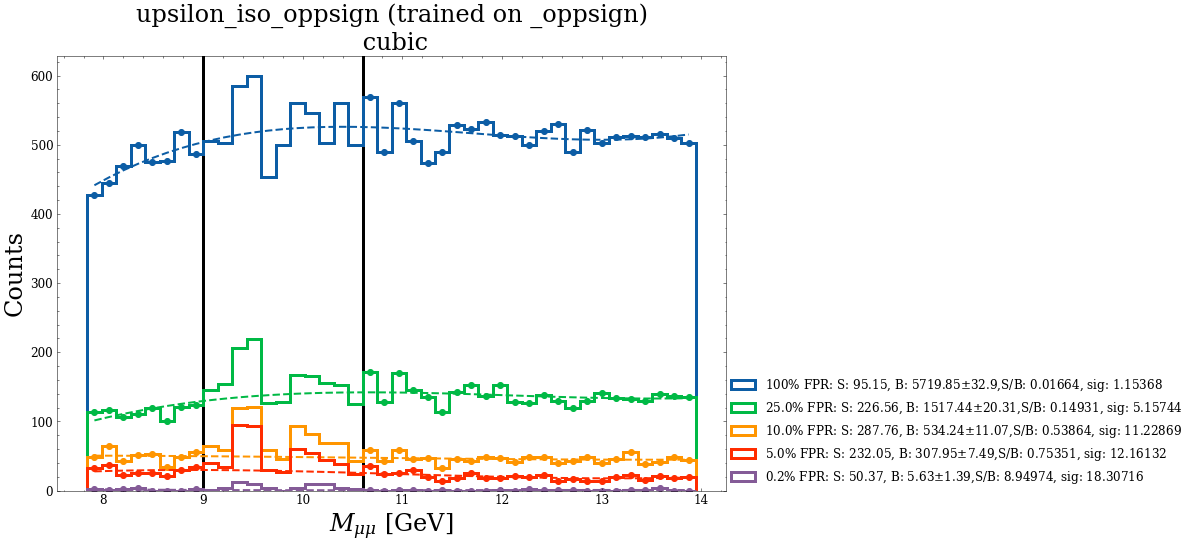

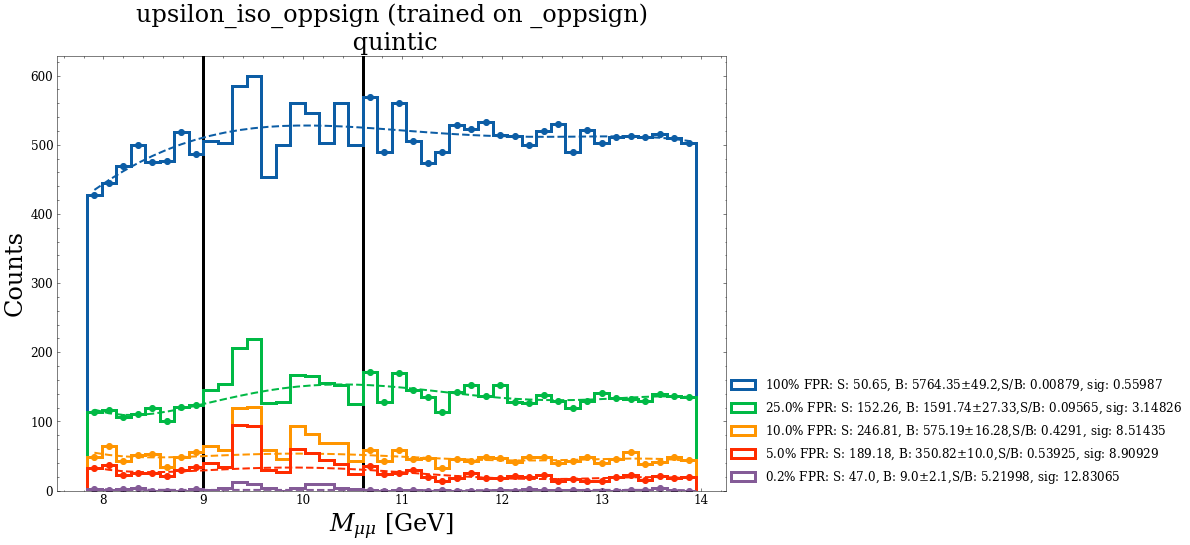

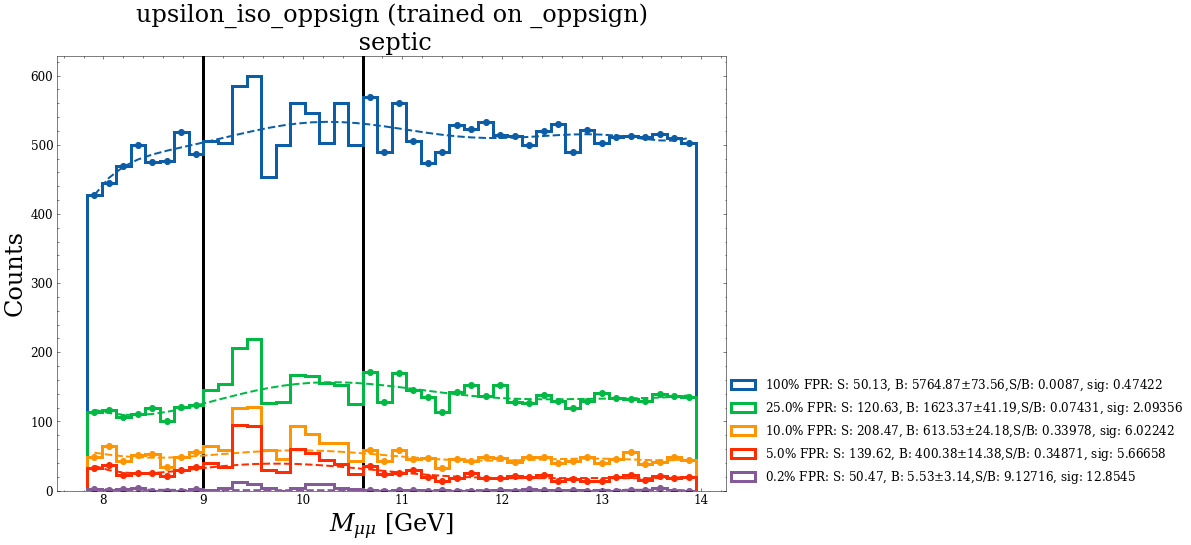

In [38]:

pseudo_e_to_plot= 0


"""
PLOT HISTOGRAM ON SMALL TEST SET
"""

fit_type = "cubic"

fpr_results_cubic = plot_histograms_with_fits(fpr_thresholds, all_test_data_splits[pseudo_e_to_plot], all_scores_splits[pseudo_e_to_plot], score_cutoffs[pseudo_e_to_plot], 
                          scaler, fit_type,f"{particle_type}{train_data_id_title} (trained on {train_data_id_title})\n cubic", 
                          SB_left, SR_left, SR_right, SB_right, take_score_avg=False)
fit_type = "quintic"
fpr_results_quintic = plot_histograms_with_fits(fpr_thresholds, all_test_data_splits[pseudo_e_to_plot], all_scores_splits[pseudo_e_to_plot], score_cutoffs[pseudo_e_to_plot], 
                          scaler, fit_type,f"{particle_type}{train_data_id_title} (trained on {train_data_id_title})\n quintic", 
                          SB_left, SR_left, SR_right, SB_right, take_score_avg=False)

fit_type = "septic"
fpr_results_septic = plot_histograms_with_fits(fpr_thresholds, all_test_data_splits[pseudo_e_to_plot], all_scores_splits[pseudo_e_to_plot], score_cutoffs[pseudo_e_to_plot], 
                          scaler, fit_type,f"{particle_type}{train_data_id_title} (trained on {train_data_id_title})\n septic", 
                          SB_left, SR_left, SR_right, SB_right, take_score_avg=False)

for f in fpr_results_septic.keys():
    print(f"Threshold {100*f}%")
    print("   cubic // quintic // septic")
    print("   num S in SR: {S_cubic} // {S_quintic} // {S_septic}".format(S_cubic=fpr_results_cubic[f]["S"],S_quintic=fpr_results_quintic[f]["S"],S_septic=fpr_results_septic[f]["S"]))
    print("   num B in SR: {S_cubic} // {S_quintic} // {S_septic}".format(S_cubic=fpr_results_cubic[f]["B"],S_quintic=fpr_results_quintic[f]["B"],S_septic=fpr_results_septic[f]["B"]))
    print("   S/B: {S_cubic} // {S_quintic} // {S_septic}".format(S_cubic=fpr_results_cubic[f]["S_over_B"],S_quintic=fpr_results_quintic[f]["S_over_B"],S_septic=fpr_results_septic[f]["S_over_B"]))
    print("   B_error: {S_cubic} // {S_quintic} // {S_septic}".format(S_cubic=fpr_results_cubic[f]["B_error"],S_quintic=fpr_results_quintic[f]["B_error"],S_septic=fpr_results_septic[f]["B_error"]))
    print("   significance: {S_cubic} // {S_quintic} // {S_septic}".format(S_cubic=fpr_results_cubic[f]["signif"],S_quintic=fpr_results_quintic[f]["signif"],S_septic=fpr_results_septic[f]["signif"]))
    print()


/global/u1/r/rmastand/dimuonAD/helpers/physics_functions.py:104: RuntimeWarning: divide by zero encountered in divide
  return np.sum((y_fit - y_true)**2/y_true)
/global/u1/r/rmastand/dimuonAD/helpers/physics_functions.py:104: RuntimeWarning: divide by zero encountered in divide
  return np.sum((y_fit - y_true)**2/y_true)
/global/u1/r/rmastand/dimuonAD/helpers/physics_functions.py:104: RuntimeWarning: divide by zero encountered in divide
  return np.sum((y_fit - y_true)**2/y_true)


Threshold 100%
   cubic // quintic // septic
   num S in SR: -160.0 // -171.0 // -335.0
   num B in SR: 5585.0 // 5596.0 // 5760.0
   S/B: -0.03 // -0.03 // -0.06
   significance: -1.94 // -1.85 // -3.23

Threshold 25.0%
   cubic // quintic // septic
   num S in SR: -128.0 // -191.0 // -255.0
   num B in SR: 1401.0 // 1464.0 // 1528.0
   S/B: -0.09 // -0.13 // -0.17
   significance: -3.08 // -3.99 // -4.94

Threshold 10.0%
   cubic // quintic // septic
   num S in SR: -94.0 // -81.0 // -85.0
   num B in SR: 507.0 // 494.0 // 498.0
   S/B: -0.19 // -0.16 // -0.17
   significance: -3.93 // -3.13 // -2.81

Threshold 5.0%
   cubic // quintic // septic
   num S in SR: 13.0 // 54.0 // 55.0
   num B in SR: 181.0 // 140.0 // 139.0
   S/B: 0.07 // 0.39 // 0.4
   significance: 0.86 // 3.68 // 3.12

Threshold 0.2%
   cubic // quintic // septic
   num S in SR: -2.0 // -4.0 // -7.0
   num B in SR: 4.0 // 6.0 // 9.0
   S/B: -0.51 // -0.67 // -0.78
   significance: -0.98 // -1.49 // -2.12



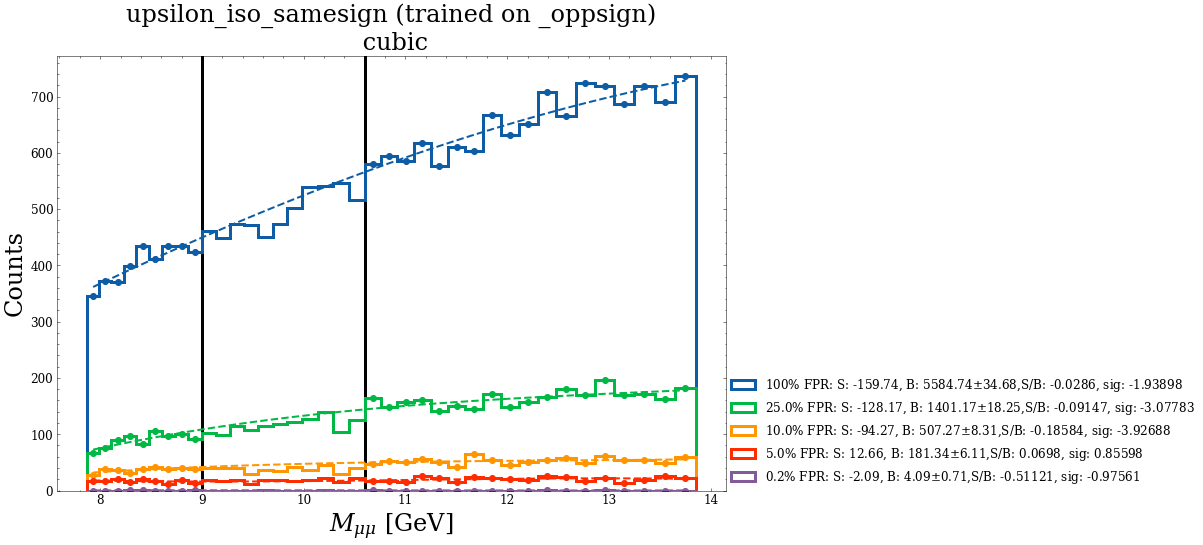

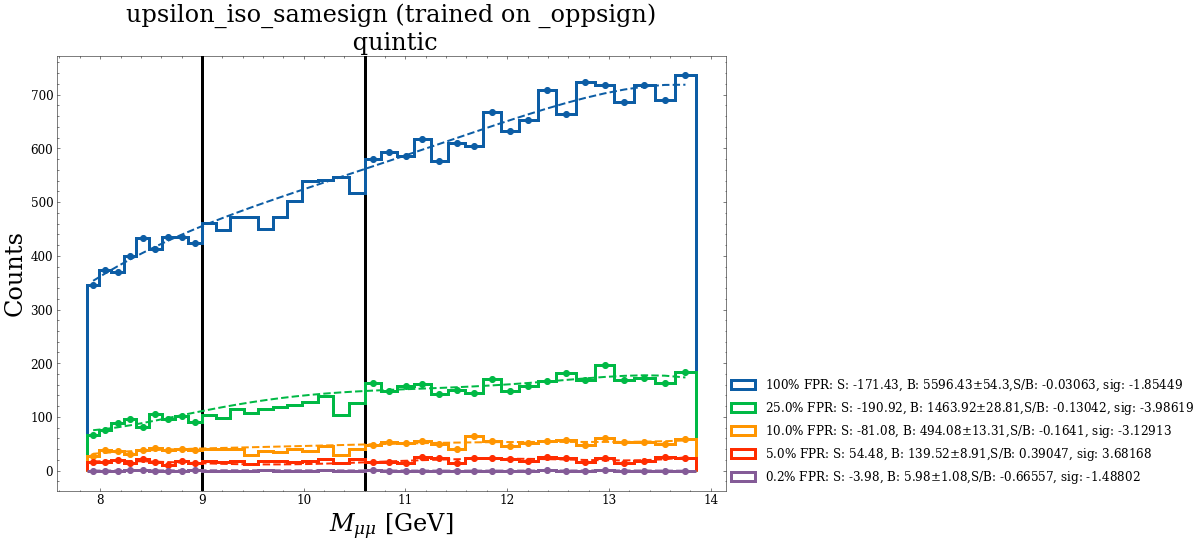

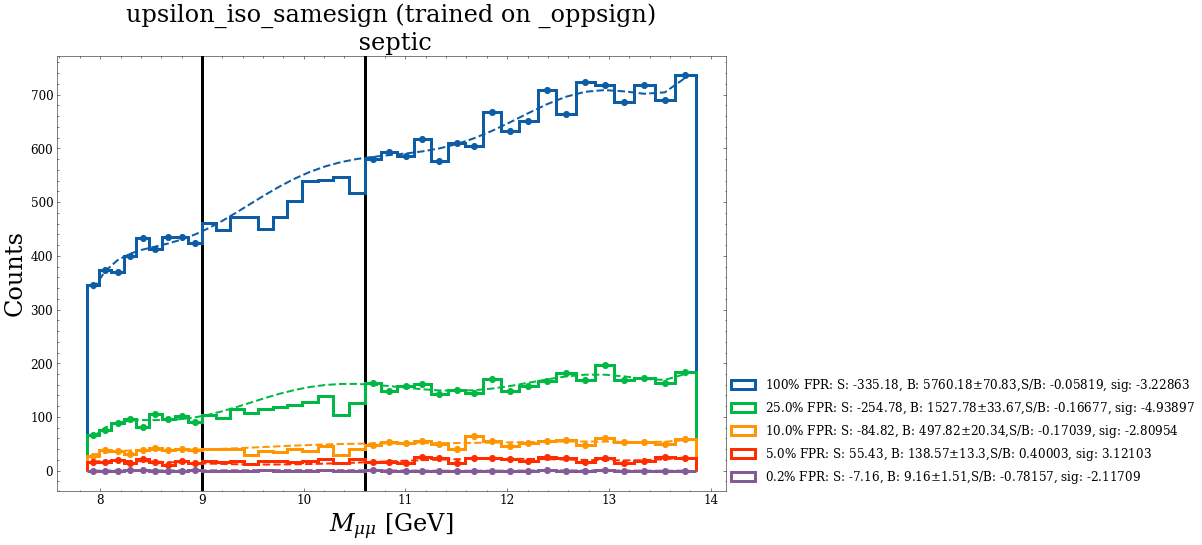

In [36]:

"""
PLOT HISTOGRAM ON ALTERNATIVE TEST SET
"""

fit_type = "cubic"
fpr_results_cubic = plot_histograms_with_fits(fpr_thresholds, all_alt_data_splits[pseudo_e_to_plot]["alt"], all_alt_scores_splits[pseudo_e_to_plot]["alt"], score_cutoffs[pseudo_e_to_plot], 
                          scaler, fit_type, f"{particle_type}{alt_test_data_id} (trained on {train_data_id_title})\n cubic"
                          ,SB_left, SR_left, SR_right, SB_right, take_score_avg=False)
fit_type = "quintic"
fpr_results_quintic = plot_histograms_with_fits(fpr_thresholds, all_alt_data_splits[pseudo_e_to_plot]["alt"], all_alt_scores_splits[pseudo_e_to_plot]["alt"], score_cutoffs[pseudo_e_to_plot], 
                          scaler, fit_type, f"{particle_type}{alt_test_data_id} (trained on {train_data_id_title})\n quintic",
                          SB_left, SR_left, SR_right, SB_right, take_score_avg=False)
fit_type = "septic"
fpr_results_septic = plot_histograms_with_fits(fpr_thresholds, all_alt_data_splits[pseudo_e_to_plot]["alt"], all_alt_scores_splits[pseudo_e_to_plot]["alt"], score_cutoffs[pseudo_e_to_plot], 
                          scaler, fit_type, f"{particle_type}{alt_test_data_id} (trained on {train_data_id_title})\n septic",
                          SB_left, SR_left, SR_right, SB_right, take_score_avg=False)

for f in fpr_results_septic.keys():
    print(f"Threshold {100*f}%")
    print("   cubic // quintic // septic")
    print("   num S in SR: {S_cubic} // {S_quintic} // {S_septic}".format(S_cubic=fpr_results_cubic[f]["S"],S_quintic=fpr_results_quintic[f]["S"],S_septic=fpr_results_septic[f]["S"]))
    print("   num B in SR: {S_cubic} // {S_quintic} // {S_septic}".format(S_cubic=fpr_results_cubic[f]["B"],S_quintic=fpr_results_quintic[f]["B"],S_septic=fpr_results_septic[f]["B"]))
    print("   S/B: {S_cubic} // {S_quintic} // {S_septic}".format(S_cubic=fpr_results_cubic[f]["S_over_B"],S_quintic=fpr_results_quintic[f]["S_over_B"],S_septic=fpr_results_septic[f]["S_over_B"]))
    print("   significance: {S_cubic} // {S_quintic} // {S_septic}".format(S_cubic=fpr_results_cubic[f]["signif"],S_quintic=fpr_results_quintic[f]["signif"],S_septic=fpr_results_septic[f]["signif"]))
    print()




In [ ]:

"""
PLOT HISTOGRAM ON ROC TEST DATA
"""
fit_type = "cubic"
fpr_results_cubic = plot_histograms_with_fits(fpr_thresholds, all_alt_data_splits[pseudo_e_to_plot]["ROC_data"], all_alt_scores_splits[pseudo_e_to_plot]["ROC_data"], score_cutoffs[pseudo_e_to_plot], scaler, fit_type,f"high-stats data _oppsign (trained on {train_data_id_title})\n"+"  ".join(feature_set[:-1])+"\n", SB_left, SR_left, SR_right, SB_right, take_score_avg=False)
fit_type = "quintic"
fpr_results_quintic = plot_histograms_with_fits(fpr_thresholds, all_alt_data_splits[pseudo_e_to_plot]["ROC_data"], all_alt_scores_splits[pseudo_e_to_plot]["ROC_data"], score_cutoffs[pseudo_e_to_plot], scaler, fit_type,f"high-stats data _oppsign (trained on {train_data_id_title})\n"+"  ".join(feature_set[:-1])+"\n", SB_left, SR_left, SR_right, SB_right, take_score_avg=False)
fit_type = "septic"
fpr_results_septic = plot_histograms_with_fits(fpr_thresholds, all_alt_data_splits[pseudo_e_to_plot]["ROC_data"], all_alt_scores_splits[pseudo_e_to_plot]["ROC_data"], score_cutoffs[pseudo_e_to_plot], scaler, fit_type,f"high-stats data _oppsign (trained on {train_data_id_title})\n"+"  ".join(feature_set[:-1])+"\n", SB_left, SR_left, SR_right, SB_right, take_score_avg=False)

for f in fpr_results_septic.keys():
    print(f"Threshold {100*f}%")
    print("   cubic // quintic // septic")
    print("   num S in SR: {S_cubic} // {S_quintic} // {S_septic}".format(S_cubic=fpr_results_cubic[f]["S"],S_quintic=fpr_results_quintic[f]["S"],S_septic=fpr_results_septic[f]["S"]))
    print("   num B in SR: {S_cubic} // {S_quintic} // {S_septic}".format(S_cubic=fpr_results_cubic[f]["B"],S_quintic=fpr_results_quintic[f]["B"],S_septic=fpr_results_septic[f]["B"]))
    print("   S/B: {S_cubic} // {S_quintic} // {S_septic}".format(S_cubic=fpr_results_cubic[f]["S_over_B"],S_quintic=fpr_results_quintic[f]["S_over_B"],S_septic=fpr_results_septic[f]["S_over_B"]))
    print("   significance: {S_cubic} // {S_quintic} // {S_septic}".format(S_cubic=fpr_results_cubic[f]["signif"],S_quintic=fpr_results_quintic[f]["signif"],S_septic=fpr_results_septic[f]["signif"]))
    print()



In [ ]:
fit_type = "cubic"
fpr_results_cubic = plot_histograms_with_fits(fpr_thresholds, all_alt_data_splits[pseudo_e_to_plot]["ROC_samples"], all_alt_scores_splits[pseudo_e_to_plot]["ROC_samples"], score_cutoffs[pseudo_e_to_plot], scaler, fit_type,f"high-stats samples {train_data_id_title} (trained on {train_data_id_title})\n"+"  ".join(feature_set[:-1])+"\n", SB_left, SR_left, SR_right, SB_right, take_score_avg=False)
fit_type = "quintic"
fpr_results_quintic = plot_histograms_with_fits(fpr_thresholds, all_alt_data_splits[pseudo_e_to_plot]["ROC_samples"], all_alt_scores_splits[pseudo_e_to_plot]["ROC_samples"], score_cutoffs[pseudo_e_to_plot], scaler, fit_type,f"high-stats samples {train_data_id_title} (trained on {train_data_id_title})\n"+"  ".join(feature_set[:-1])+"\n", SB_left, SR_left, SR_right, SB_right, take_score_avg=False)
fit_type = "septic"
fpr_results_septic = plot_histograms_with_fits(fpr_thresholds, all_alt_data_splits[pseudo_e_to_plot]["ROC_samples"], all_alt_scores_splits[pseudo_e_to_plot]["ROC_samples"], score_cutoffs[pseudo_e_to_plot], scaler, fit_type,f"high-stats samples {train_data_id_title} (trained on {train_data_id_title})\n"+"  ".join(feature_set[:-1])+"\n", SB_left, SR_left, SR_right, SB_right, take_score_avg=False)

for f in fpr_results_septic.keys():
    print(f"Threshold {100*f}%")
    print("   cubic // quintic // septic")
    print("   num S in SR: {S_cubic} // {S_quintic} // {S_septic}".format(S_cubic=fpr_results_cubic[f]["S"],S_quintic=fpr_results_quintic[f]["S"],S_septic=fpr_results_septic[f]["S"]))
    print("   num B in SR: {S_cubic} // {S_quintic} // {S_septic}".format(S_cubic=fpr_results_cubic[f]["B"],S_quintic=fpr_results_quintic[f]["B"],S_septic=fpr_results_septic[f]["B"]))
    print("   S/B: {S_cubic} // {S_quintic} // {S_septic}".format(S_cubic=fpr_results_cubic[f]["S_over_B"],S_quintic=fpr_results_quintic[f]["S_over_B"],S_septic=fpr_results_septic[f]["S_over_B"]))
    print("   significance: {S_cubic} // {S_quintic} // {S_septic}".format(S_cubic=fpr_results_cubic[f]["signif"],S_quintic=fpr_results_quintic[f]["signif"],S_septic=fpr_results_septic[f]["signif"]))
    print()
